# 1.Data preparation

Before training our model, we need to preprocess our data slightly.

In [1]:
# Importing all libraries we will use
import pandas as pd
import numpy as np
import tensorflow as tf
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from scipy.stats import boxcox
import matplotlib.pyplot as plt
import joblib
import shap


In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_csv('/content/drive/MyDrive/Spotify_Recommendation_Engine/RAW_DATA/Music Info.csv')

In [4]:
data

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50678,TRQYCFV128F9322F50,Ryusei Rocket,アンティック-珈琲店-,https://p.scdn.co/mp3-preview/d2668a5a3e0b1fda...,0tt1RdeJX1RyuU4hMEZ19T,NaN,NaN,2008,273440,0.438,...,6,-3.062,0,0.1650,0.003120,0.000000,0.1300,0.421,166.956,4
50679,TRHQCSH128F42724B7,Colors Of The Wind,ACIDMAN,https://p.scdn.co/mp3-preview/8e22a7052ef3ecf7...,3wkdfXGf5JYErW4b35zP2h,"rock, alternative_rock, japanese, cover",NaN,2004,275133,0.351,...,0,-6.811,1,0.1200,0.000940,0.000049,0.1920,0.450,200.350,4
50680,TRZRODK128F92D68D7,The Revelation,coldrain,https://p.scdn.co/mp3-preview/4b51a813f67e3853...,1gXMORZRGA40PE9rDE9cja,"metal, metalcore, post_hardcore",NaN,2014,254826,0.434,...,10,-3.092,0,0.2680,0.000108,0.001410,0.1630,0.282,158.025,4
50681,TRGLMEM128F9322F63,Koi no Dependence,アンティック-珈琲店-,https://p.scdn.co/mp3-preview/5a61e031df174666...,1dxMDGvIYHFYgRvmw1uMHG,NaN,NaN,2008,243293,0.513,...,4,-3.914,0,0.0530,0.000715,0.001350,0.0571,0.618,109.923,4


First, we need to examine the distribution of the data to ensure there are no errors. We will not drop any outliers at this stage. Music genres are not linear values; therefore, numbers that might appear as outliers may simply represent different genres characterized by more distant values.




**Numerical Columns**

These columns do not require any preprocessing as they are already in an appropriate format for use in the model. Most of them are even scaled from 0 to 1. We only need to make minor adjustments for cosmetic purposes.

**Categorical Columns**

Not all categorical columns are necessary, but those we need must be preprocessed. The only categorical columns required are tags and artists. Columns such as names, URLs, or IDs do not provide valuable information about the genre.




We can convert duration_ms to duration_s, as such high precision is unnecessary. Additionally, large numbers like duration in milliseconds can negatively impact the weights of our model

In [5]:
# Change name of column
data = data.rename(columns={'duration_ms': 'duration_s'})
# Division by 1000
data['duration_s'] = data['duration_s'] / 1000

Now we can create embeddings for our tags. However, before doing so, we need to analyze some statistics to better understand what these tags truly represent.

In [6]:

# 1. Count the number of unique tag combinations
unique_tags = data['tags'].nunique()
print(f"Number of unique tag combinations: {unique_tags}")

# 2. Display the most common tags
tags_split = data['tags'].str.split(',').explode().str.strip()
top_tags = tags_split.value_counts().head(10)
print("\nTop 10 most common tags:")
print(top_tags)

# 3. Count the occurrences of unique tag combinations
tag_combinations = data['tags'].value_counts().head(10)
print("\nTop 10 most common tag combinations:")
print(tag_combinations)

# 4. Check correlation between tags and genres by grouping with index to avoid duplicates
tags_split_with_index = tags_split.reset_index(drop=True)
tag_genre_correlation = pd.crosstab(tags_split_with_index, data['genre'])

# Filter only the top tags without reindexing
print("\nTag-Genre correlation (Top tags with genres):")
print(tag_genre_correlation.loc[tag_genre_correlation.index.isin(top_tags.index)].head(10))


Number of unique tag combinations: 20057

Top 10 most common tags:
tags
rock                10684
indie                7287
electronic           6594
alternative          6274
pop                  4651
female_vocalists     4517
alternative_rock     4137
indie_rock           3801
metal                3181
classic_rock         2779
Name: count, dtype: int64

Top 10 most common tag combinations:
tags
country                   506
reggae                    454
black_metal               442
rap, hip_hop              378
drum_and_bass             365
ska                       305
industrial                283
grindcore                 279
death_metal, grindcore    277
jazz                      240
Name: count, dtype: int64

Tag-Genre correlation (Top tags with genres):
genre             Blues  Country  Electronic  Folk  Jazz  Latin  Metal  \
tags                                                                     
alternative           5       73         195    31    43      1    144   
alte

There is a significant issue with the tags.

**Our dataset is heavily rock-centered.**
Not only is rock the most common genre, but many of the most frequent tags are also rock-related. This is the same situation observed in our Power BI report. Rock clearly dominates the dataset, even in the tags.

However, the biggest issue is that these tags do not appear to be assigned properly.

**Some examples:**

Electronic genre:
The "Electronic" tag appears only 92 times, whereas tags related to rock occur, on average, 100–200 times.

**This issue is present across all genres.**
In many cases, tags associated with the rock genre appear more frequently than tags related to the actual genre.

Despite this issue, we must acknowledge that tags are an important part of our data and hold valuable information, even if they are not assigned as accurately as we would like. However, these inconsistencies could potentially harm our model's performance.

**To explore all possibilities and determine the best approach, we will train two models: one using the data with tags and another using the data without them.**

In [7]:
# Dropping NAN's in tags columns
data = data.dropna(subset=['tags'])

In [8]:
# Separating tags
data['tags'] = data['tags'].str.split(',')

In [9]:
data['tags'].iloc[0][0]

'rock'

In [10]:
len(data['tags'])

49556

Embedding tags

In [11]:


# Step 1: Replace NaN values in 'tags' with empty lists and strip spaces from each tag
data['tags'] = data['tags'].apply(lambda x: [tag.strip() for tag in x] if isinstance(x, list) else [])

# Step 2: Flatten the tag lists to encode all unique tags
all_tags = [tag for tags in data['tags'] for tag in tags]
label_encoder = LabelEncoder()
label_encoder.fit(all_tags)

# Parameters for Embedding
num_tags = len(label_encoder.classes_)
embedding_dim = 8

# Step 3: Initialize the Embedding Layer for Tags
tag_embedding_layer = tf.keras.layers.Embedding(input_dim=num_tags, output_dim=embedding_dim)

# Step 4: Generate Embeddings for Each Tag in Each Item
def embed_tags(tags_encoded):
    tag_embeddings = tag_embedding_layer(tf.constant(tags_encoded))
    return np.mean(tag_embeddings.numpy(), axis=0)

# Step 5: Encode tags and create an averaged embedding for each item
data['tags_encoded'] = data['tags'].apply(lambda tags: label_encoder.transform(tags))
data['tags_embedding'] = data['tags_encoded'].apply(embed_tags)

# Step 6: Convert the embeddings to a DataFrame
tags_embeddings_df = pd.DataFrame(data['tags_embedding'].tolist(), columns=[f'tag_emb_{i}' for i in range(embedding_dim)])

# Step 7: Concatenate the tag embeddings back to the original DataFrame
data = pd.concat([data, tags_embeddings_df], axis=1)

data = data.drop(columns=['tags', 'tags_encoded', 'tags_embedding'])


In [12]:
encoded_tags_list = label_encoder.classes_
print("List of encoded tags:", encoded_tags_list)


List of encoded tags: ['00s' '60s' '70s' '80s' '90s' 'acoustic' 'alternative' 'alternative_rock'
 'ambient' 'american' 'avant_garde' 'beautiful' 'black_metal' 'blues'
 'blues_rock' 'british' 'britpop' 'chill' 'chillout' 'classic_rock'
 'classical' 'country' 'cover' 'dance' 'dark_ambient' 'death_metal'
 'doom_metal' 'downtempo' 'drum_and_bass' 'electro' 'electronic' 'emo'
 'experimental' 'female_vocalists' 'folk' 'french' 'funk' 'german'
 'gothic' 'gothic_metal' 'grindcore' 'grunge' 'guitar' 'hard_rock'
 'hardcore' 'heavy_metal' 'hip_hop' 'house' 'idm' 'indie' 'indie_pop'
 'indie_rock' 'industrial' 'instrumental' 'j_pop' 'japanese' 'jazz'
 'lounge' 'love' 'male_vocalists' 'mellow' 'melodic_death_metal' 'metal'
 'metalcore' 'new_age' 'new_wave' 'noise' 'nu_metal' 'oldies' 'piano'
 'polish' 'pop' 'pop_rock' 'post_hardcore' 'post_punk' 'post_rock'
 'power_metal' 'progressive_metal' 'progressive_rock' 'psychedelic'
 'psychedelic_rock' 'punk' 'punk_rock' 'rap' 'reggae' 'rnb' 'rock'
 'russian

In [13]:
len(encoded_tags_list)

100

In [14]:
print(data.columns)


Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'genre', 'year', 'duration_s', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'tag_emb_0',
       'tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4', 'tag_emb_5',
       'tag_emb_6', 'tag_emb_7'],
      dtype='object')


**We will apply the same approach to artists.**


**They do not need to undergo A/B testing**, as tags were created and assigned by the dataset's creator, which explains the many inconsistencies. **Artists, however, could not have been assigned improperly.**

In [15]:
data

,track_id,name,artist,spotify_preview_url,spotify_id,genre,year,duration_s,danceability,energy,...,tempo,time_signature,tag_emb_0,tag_emb_1,tag_emb_2,tag_emb_3,tag_emb_4,tag_emb_5,tag_emb_6,tag_emb_7
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,NaN,2004.0,222.200,0.355,0.918,...,148.114,4.0,0.008834,-0.016678,0.014554,-0.016675,-0.012928,-0.008644,-0.008108,0.006119
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,NaN,2006.0,258.613,0.409,0.892,...,174.426,4.0,0.006313,-0.007052,0.017966,-0.005063,-0.010768,-0.003960,-0.015781,0.011439
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,RnB,1991.0,218.920,0.508,0.826,...,120.012,4.0,0.000122,0.005568,0.015076,-0.009816,0.010489,-0.016324,-0.026367,0.006989
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,NaN,2004.0,237.026,0.279,0.664,...,104.560,4.0,-0.001398,-0.005417,0.014455,-0.012829,-0.018296,-0.006070,-0.006994,0.008676
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,RnB,2008.0,238.640,0.515,0.430,...,91.841,4.0,0.002190,-0.004462,0.010143,-0.008438,-0.008271,-0.007197,-0.014311,0.010589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.023464,0.015678,0.002593,0.001169,0.007271,-0.022845,0.016797,-0.013350
49551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.009025,-0.017360,-0.016608,0.035260,0.028881,0.000813,-0.007452,0.037669
49552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.003762,-0.012990,-0.021408,-0.042030,0.025783,-0.026856,-0.009097,0.042746
49553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.011457,-0.008410,0.013970,-0.015679,0.012354,-0.002498,-0.028417,0.004480


In [16]:
unique_artist_count = data['artist'].nunique()
print(unique_artist_count)


8065


In [17]:


num_artists = unique_artist_count
embedding_dim = 16

# Step 1: Initialize the Embedding layer
artist_embedding_layer = tf.keras.layers.Embedding(input_dim=num_artists, output_dim=embedding_dim)

# Step 2: Initialize the weights by calling the layer with sample data
_ = artist_embedding_layer(tf.constant([0]))

# Step 3: Get the embedding matrix after initialization
embedding_matrix = artist_embedding_layer.get_weights()[0]

# Step 4: Example of how to retrieve the embedding for a specific artist ID
artist_id = 10
artist_vector = embedding_matrix[artist_id]
print("Embedding vector for artist ID 10:", artist_vector)


Embedding vector for artist ID 10: [ 0.03366086  0.03054399 -0.03886583 -0.03829038 -0.02206482  0.0020945
 -0.00396352 -0.00438126  0.01388227  0.01596186  0.00934408 -0.00585207
  0.03301286 -0.00567729  0.04374737  0.04247976]


In [18]:

if 'artist_encoded' not in data.columns:
    label_encoder = LabelEncoder()
    data['artist_encoded'] = label_encoder.fit_transform(data['artist'])

embedding_df = pd.DataFrame(embedding_matrix)

embedding_df.columns = [f'artist_emb_{i}' for i in range(embedding_dim)]


data = data.join(embedding_df, on='artist_encoded')


In [19]:
data.columns.tolist()

['track_id',
 'name',
 'artist',
 'spotify_preview_url',
 'spotify_id',
 'genre',
 'year',
 'duration_s',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'tag_emb_0',
 'tag_emb_1',
 'tag_emb_2',
 'tag_emb_3',
 'tag_emb_4',
 'tag_emb_5',
 'tag_emb_6',
 'tag_emb_7',
 'artist_encoded',
 'artist_emb_0',
 'artist_emb_1',
 'artist_emb_2',
 'artist_emb_3',
 'artist_emb_4',
 'artist_emb_5',
 'artist_emb_6',
 'artist_emb_7',
 'artist_emb_8',
 'artist_emb_9',
 'artist_emb_10',
 'artist_emb_11',
 'artist_emb_12',
 'artist_emb_13',
 'artist_emb_14',
 'artist_emb_15']

We can drop the columns we do not need for now and handle the remaining NaNs.

In [20]:
nan_rows_count = data.drop(columns=['genre']).isna().any(axis=1).sum()
print("Number of rows with NaNs (excluding 'genre' column):", nan_rows_count)


Number of rows with NaNs (excluding 'genre' column): 1684


In [21]:
# Drop rows with NaNs in any column except 'genre'
data = data.dropna(subset=[col for col in data.columns if col != 'genre']).reset_index(drop=True)


In [22]:
data

,track_id,name,artist,spotify_preview_url,spotify_id,genre,year,duration_s,danceability,energy,...,artist_emb_6,artist_emb_7,artist_emb_8,artist_emb_9,artist_emb_10,artist_emb_11,artist_emb_12,artist_emb_13,artist_emb_14,artist_emb_15
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,NaN,2004.0,222.200,0.355,0.918,...,-0.048214,-0.014687,0.008213,-0.023262,0.013554,-0.029978,-0.005231,0.049390,0.014932,-0.011230
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,NaN,2006.0,258.613,0.409,0.892,...,-0.011413,-0.038481,-0.015207,-0.041898,0.021524,0.010594,-0.037056,-0.023038,0.016239,0.031176
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,RnB,1991.0,218.920,0.508,0.826,...,-0.002007,0.043474,0.023989,0.040391,-0.032456,-0.044583,-0.037190,-0.032003,-0.048909,-0.049871
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,NaN,2004.0,237.026,0.279,0.664,...,0.017858,-0.012711,-0.000289,-0.027508,-0.005744,0.047212,0.038340,0.019354,0.036434,-0.021568
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,RnB,2008.0,238.640,0.515,0.430,...,0.041348,0.024945,0.012280,0.042209,0.004481,-0.025919,-0.029856,0.019153,0.029773,0.017890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48709,TRYPREG128F935A44E,Salt & pepper,Kaizers Orchestra,https://p.scdn.co/mp3-preview/33b033c6a4299342...,000XUp5RmUftwfG2hCkS7q,Rock,2003.0,282.827,0.522,0.642,...,0.005546,-0.043007,0.018893,-0.029003,0.037397,-0.009688,0.037028,0.015354,-0.023693,0.001914
48710,TRQHYEL128F424D801,Amor Al Arte,Orishas,https://p.scdn.co/mp3-preview/fa48af1f0ae6099e...,3SD2KUYOlTirkomIkIvCZY,NaN,2005.0,246.506,0.931,0.756,...,0.000469,-0.022064,-0.016635,-0.023735,-0.033277,-0.033718,0.049222,-0.025324,0.026452,0.015453
48711,TRDCVVU128F425226C,Roses & Hips,Keren Ann,https://p.scdn.co/mp3-preview/c01a8ce86de56c62...,0bq6wbvByIeuVrXnQs4EdR,NaN,2004.0,214.600,0.675,0.440,...,0.046841,0.038105,-0.040503,-0.049116,-0.028248,0.041472,0.041999,-0.005586,0.014191,-0.001019
48712,TRWACEH128F42A8AA0,Ubriaco Canta Amore,Bandabardò,https://p.scdn.co/mp3-preview/22ab080ed0544805...,0FG7l1hzB1V9Aa7TO1w1ZV,Folk,1998.0,212.133,0.792,0.896,...,0.043810,-0.027105,0.007900,0.021976,-0.002491,0.011190,-0.003027,0.018379,-0.000230,0.045858


A few numerical features have highly skewed distributions, which need to be addressed. We will apply a Box-Cox transformation to correct this.

Optimal lambda for speechiness: -0.06624379840228446
Optimal lambda for instrumentalness: 0.02108274072317325
Optimal lambda for acousticness: 0.11815170370262276


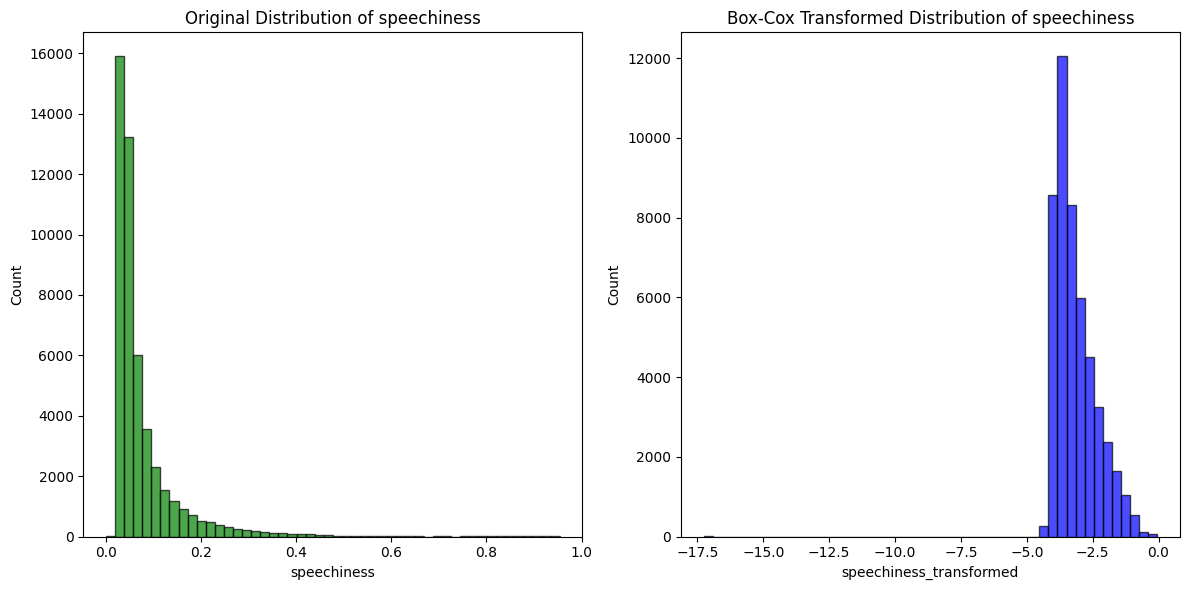

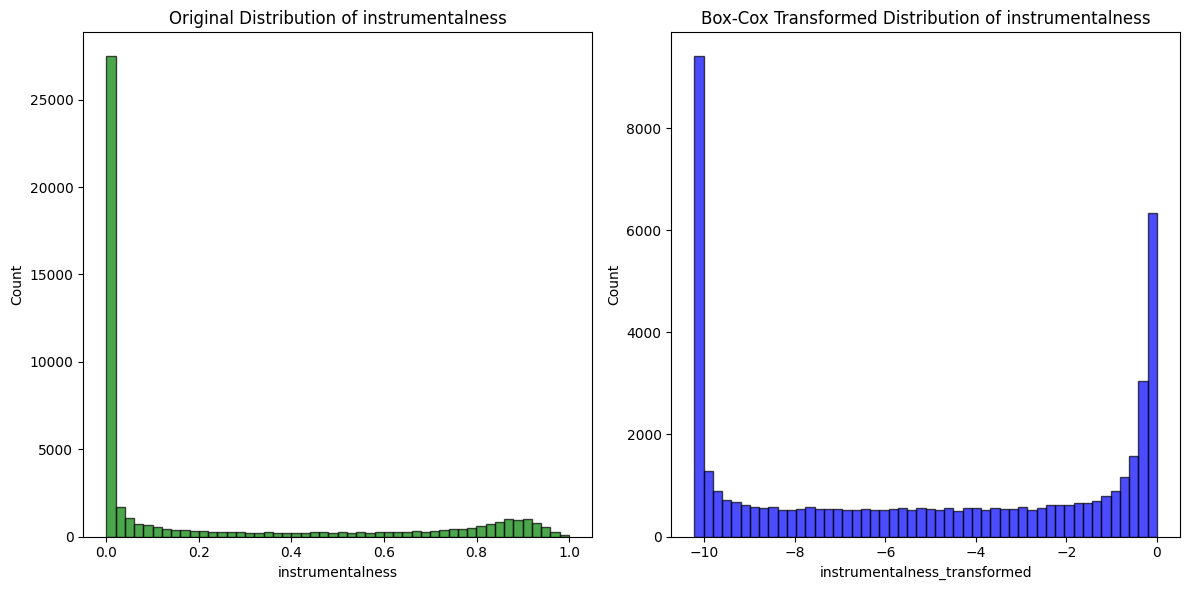

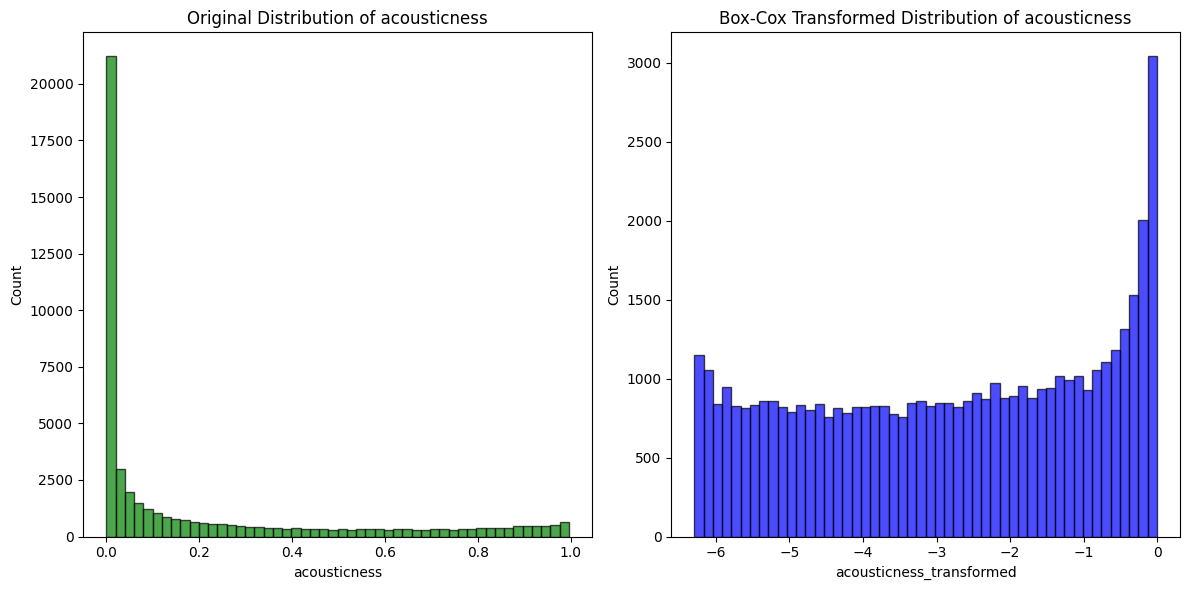

In [23]:

# Columns to transform
columns_to_transform = ['speechiness', 'instrumentalness', 'acousticness']

# BoxCox transformation
for col in columns_to_transform:
    if (data[col] <= 0).any():
        data[col] += np.abs(data[col].min()) + 1e-5


    data[f'{col}_transformed'], lambda_optimal = boxcox(data[col])

    print(f"Optimal lambda for {col}: {lambda_optimal}")


for col in columns_to_transform:
    plt.figure(figsize=(12, 6))

    # Original Distribution
    plt.subplot(1, 2, 1)
    plt.hist(data[col], bins=50, color='green', alpha=0.7, edgecolor='black')
    plt.title(f'Original Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')

    # Transformed Distribution
    plt.subplot(1, 2, 2)
    plt.hist(data[f'{col}_transformed'], bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f'Box-Cox Transformed Distribution of {col}')
    plt.xlabel(f'{col}_transformed')
    plt.ylabel('Count')

    plt.tight_layout()
    plt.show()


Although it is still not ideal, the result is much better than it was before the transformation.

In [24]:
# Drop old columns
data.drop(columns=['speechiness', 'instrumentalness', 'acousticness'], inplace=True)


data.rename(columns={
    'speechiness_transformed': 'speechiness',
    'instrumentalness_transformed': 'instrumentalness',
    'acousticness_transformed': 'acousticness'
}, inplace=True)



In [25]:


scaler = MinMaxScaler()

# Columns to scale
columns_to_scale = ['speechiness', 'instrumentalness', 'acousticness']

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

print(data[columns_to_scale].describe())


        speechiness  instrumentalness  acousticness
count  48714.000000      48714.000000  48714.000000
mean       0.819701          0.502241      0.552905
std        0.046120          0.384826      0.311035
min        0.000000          0.000000      0.000000
25%        0.785205          0.076161      0.278440
50%        0.807449          0.516212      0.577667
75%        0.845465          0.919149      0.839557
max        1.000000          1.000000      1.000000


In [26]:
data

,track_id,name,artist,spotify_preview_url,spotify_id,genre,year,duration_s,danceability,energy,...,artist_emb_9,artist_emb_10,artist_emb_11,artist_emb_12,artist_emb_13,artist_emb_14,artist_emb_15,speechiness,instrumentalness,acousticness
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,NaN,2004.0,222.200,0.355,0.918,...,-0.023262,0.013554,-0.029978,-0.005231,0.049390,0.014932,-0.011230,0.838299,0.000000,0.262689
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,NaN,2006.0,258.613,0.409,0.892,...,-0.041898,0.021524,0.010594,-0.037056,-0.023038,0.016239,0.031176,0.781829,0.000000,0.235687
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,RnB,1991.0,218.920,0.508,0.826,...,0.040391,-0.032456,-0.044583,-0.037190,-0.032003,-0.048909,-0.049871,0.794428,0.307650,0.142164
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,NaN,2004.0,237.026,0.279,0.664,...,-0.027508,-0.005744,0.047212,0.038340,0.019354,0.036434,-0.021568,0.789008,0.336822,0.188511
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,RnB,2008.0,238.640,0.515,0.430,...,0.042209,0.004481,-0.025919,-0.029856,0.019153,0.029773,0.017890,0.788617,0.214433,0.437715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48709,TRYPREG128F935A44E,Salt & pepper,Kaizers Orchestra,https://p.scdn.co/mp3-preview/33b033c6a4299342...,000XUp5RmUftwfG2hCkS7q,Rock,2003.0,282.827,0.522,0.642,...,-0.029003,0.037397,-0.009688,0.037028,0.015354,-0.023693,0.001914,0.774772,0.000000,0.530774
48710,TRQHYEL128F424D801,Amor Al Arte,Orishas,https://p.scdn.co/mp3-preview/fa48af1f0ae6099e...,3SD2KUYOlTirkomIkIvCZY,NaN,2005.0,246.506,0.931,0.756,...,-0.023735,-0.033277,-0.033718,0.049222,-0.025324,0.026452,0.015453,0.899076,0.009256,0.608262
48711,TRDCVVU128F425226C,Roses & Hips,Keren Ann,https://p.scdn.co/mp3-preview/c01a8ce86de56c62...,0bq6wbvByIeuVrXnQs4EdR,NaN,2004.0,214.600,0.675,0.440,...,-0.049116,-0.028248,0.041472,0.041999,-0.005586,0.014191,-0.001019,0.761015,0.843372,0.891244
48712,TRWACEH128F42A8AA0,Ubriaco Canta Amore,Bandabardò,https://p.scdn.co/mp3-preview/22ab080ed0544805...,0FG7l1hzB1V9Aa7TO1w1ZV,Folk,1998.0,212.133,0.792,0.896,...,0.021976,-0.002491,0.011190,-0.003027,0.018379,-0.000230,0.045858,0.797758,0.572573,0.949183


In [27]:
data.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'genre', 'year', 'duration_s', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'tag_emb_0', 'tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4',
       'tag_emb_5', 'tag_emb_6', 'tag_emb_7', 'artist_encoded', 'artist_emb_0',
       'artist_emb_1', 'artist_emb_2', 'artist_emb_3', 'artist_emb_4',
       'artist_emb_5', 'artist_emb_6', 'artist_emb_7', 'artist_emb_8',
       'artist_emb_9', 'artist_emb_10', 'artist_emb_11', 'artist_emb_12',
       'artist_emb_13', 'artist_emb_14', 'artist_emb_15', 'speechiness',
       'instrumentalness', 'acousticness'],
      dtype='object')

The final step is to partition the dataset into a train-test split and encode the genres in y.

In [28]:
data_known_genre = data[data['genre'].notna()].reset_index(drop=True)
data_unknown_genre = data[data['genre'].isna()].reset_index(drop=True)
columns_to_exclude = ['track_id', 'name', 'artist','artist_encoded','spotify_id','spotify_preview_url']

X = data_known_genre.drop(columns=columns_to_exclude + ['genre'])
y = data_known_genre['genre']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)


X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


From several model tests conducted in a separate notebook (to save space here), XGBoost emerged as the best-performing model. It outperformed models such as Naive Bayes and simple neural networks, achieving approximately 65% accuracy, while the others barely exceeded 50%.


# 2.Tags AB testing

Here, we will test whether tags improve genre prediction or hinder it. We will use two identical models with only one difference: one will be trained on data that includes tags, and the other on data without tags.

## 2.1 Model with tags

In [29]:

params = {
    'subsample': 0.7,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.15,
    'gamma': 0.3,
    'colsample_bytree': 0.7
}

xgb_model_with_tags = XGBClassifier(
    **params,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_with_tags.fit(X_train, y_train)

print("\nXGBoost model parameters:", params)



XGBoost model parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [30]:
y_pred_best = xgb_model_with_tags.predict(X_val)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_val, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Blues       0.50      0.05      0.10        37
     Country       0.76      0.43      0.55       131
  Electronic       0.75      0.71      0.73       735
        Folk       0.81      0.33      0.47        51
        Jazz       0.70      0.31      0.43       150
       Latin       1.00      0.18      0.30        17
       Metal       0.76      0.75      0.76       461
     New Age       0.73      0.41      0.52        39
         Pop       0.60      0.25      0.35       216
        Punk       0.92      0.33      0.48        70
         Rap       0.76      0.42      0.54       175
      Reggae       0.77      0.47      0.58       134
         RnB       0.51      0.19      0.27       123
        Rock       0.68      0.91      0.78      1973
       World       1.00      0.09      0.17        11

    accuracy                           0.70      4323
   macro avg       0.75      0.39 

**Accuracy: 70%**

As mentioned earlier, I tested several different models, and XGBoost achieved an accuracy of approximately 65%. Let us consider 65% as the baseline for comparison.

The observed improvement in accuracy may be attributed to better data preparation, such as transforming skewed data and other preprocessing steps.

In [31]:
X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])

if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])

y_pred_unknown = xgb_model_with_tags.predict(X_unknown)

data_predicted_genre = data_unknown_genre.copy()

predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})


<Figure size 1400x800 with 0 Axes>

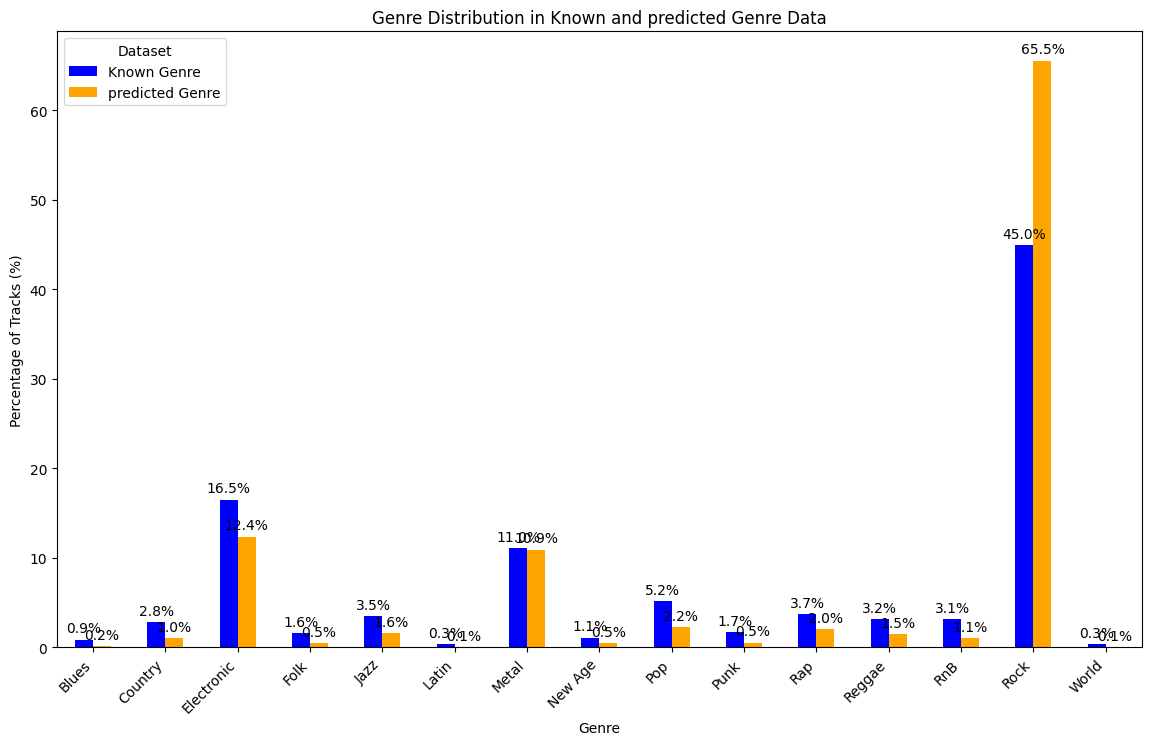

In [32]:

known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)

# Ploting the distributions
plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


This is our major issue: the distribution of the predicted data.

We can clearly observe the behavior of our model. From our report, we understand the characteristics of this dataset.

The rock genre is not only dominant but also exhibits numerical feature values that align closely with the averages of these features across the entire dataset.

It almost appears as though this dataset is primarily about rock, with other genres serving as noise or outliers.

This explains why the model is predicting genres in this way. Statistically, it is logical to predict the genre that has the most average feature values and is the most frequent. The rock genre becomes the "safest choice" for the model.

In [33]:
label_encoder = LabelEncoder()
data_predicted_genre['genre'] = label_encoder.fit_transform(data_predicted_genre['genre'])

filtered_data = data_predicted_genre.copy()

filtered_data = filtered_data.drop(columns=columns_to_exclude + ['genre'])

We will conduct SHAP analysis after each model to observe how the importance of specific features changes impact predictions of rock genre

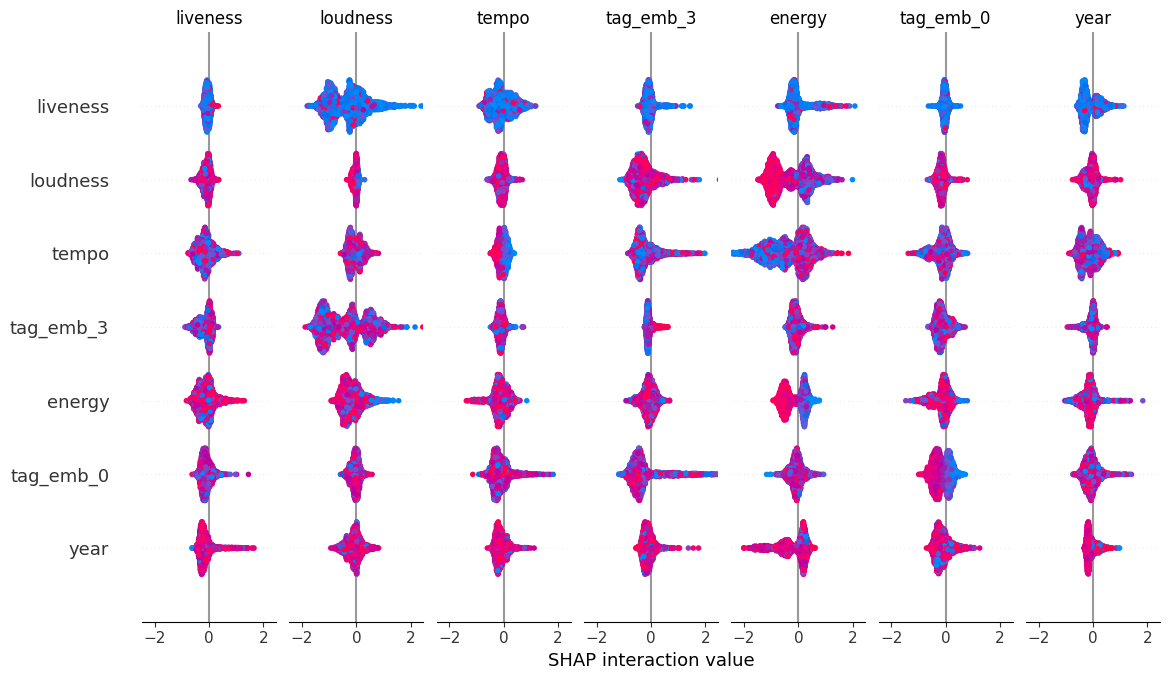

In [34]:
sampled_data_for_shap = filtered_data.sample(frac=0.1, random_state=42)

explainer = shap.TreeExplainer(xgb_model_with_tags)

shap_values = explainer.shap_values(sampled_data_for_shap)

shap.summary_plot(shap_values, sampled_data_for_shap)

**Key Features:**
*   Tags (tag_emb_3, tag_emb_0) were the most influential features in predictions.
*   Numerical features like energy, tempo, and year also contributed, but their impact was overshadowed by the dominance of tag embeddings.

**Insights:**
*   The model exhibited a rock-centric bias, heavily influenced by tags.
*   Tags added value but introduced a strong genre-specific skew, particularly favoring "rock."



## 2.2. Model without tags

In [35]:
data.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'genre', 'year', 'duration_s', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'tag_emb_0', 'tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4',
       'tag_emb_5', 'tag_emb_6', 'tag_emb_7', 'artist_encoded', 'artist_emb_0',
       'artist_emb_1', 'artist_emb_2', 'artist_emb_3', 'artist_emb_4',
       'artist_emb_5', 'artist_emb_6', 'artist_emb_7', 'artist_emb_8',
       'artist_emb_9', 'artist_emb_10', 'artist_emb_11', 'artist_emb_12',
       'artist_emb_13', 'artist_emb_14', 'artist_emb_15', 'speechiness',
       'instrumentalness', 'acousticness'],
      dtype='object')

We drop the columns containing embedded tags

In [84]:
columns_to_drop = ['tag_emb_0','tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4', 'tag_emb_5','tag_emb_6', 'tag_emb_7']
X = X.drop(columns=columns_to_drop, errors='ignore')

X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [37]:
params = {
    'subsample': 0.7,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.15,
    'gamma': 0.3,
    'colsample_bytree': 0.7
}

xgb_model_without_tags = XGBClassifier(
    **params,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_without_tags.fit(X_train, y_train)

print("\nXGBoost model parameters:", params)



XGBoost model parameters: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.15, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [38]:

y_pred_best = xgb_model_without_tags.predict(X_val)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_val, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Blues       0.43      0.08      0.14        37
     Country       0.74      0.30      0.42       131
  Electronic       0.76      0.71      0.74       735
        Folk       0.79      0.43      0.56        51
        Jazz       0.73      0.34      0.46       150
       Latin       1.00      0.24      0.38        17
       Metal       0.79      0.76      0.78       461
     New Age       0.76      0.41      0.53        39
         Pop       0.61      0.30      0.40       216
        Punk       0.84      0.39      0.53        70
         Rap       0.67      0.43      0.52       175
      Reggae       0.78      0.46      0.58       134
         RnB       0.55      0.24      0.33       123
        Rock       0.69      0.91      0.78      1973
       World       0.00      0.00      0.00        11

    accuracy                           0.71      4323
   macro avg       0.68      0.40 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Accuracy: 70%**

There is no significant difference between these two models. The accuracy is identical.

The only notable difference is that minor genres appear to be slightly better represented. For example, the precision for the "World" genre increased from 0 to 1. Although "World" has only 11 tracks, this is a positive sign.

Even though there is no difference in accuracy, the model without tags is the preferred choice.

In [39]:
data_unknown_genre = data_unknown_genre.drop(columns=columns_to_drop, errors='ignore')

In [40]:
data_unknown_genre.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'genre', 'year', 'duration_s', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'artist_encoded', 'artist_emb_0', 'artist_emb_1', 'artist_emb_2',
       'artist_emb_3', 'artist_emb_4', 'artist_emb_5', 'artist_emb_6',
       'artist_emb_7', 'artist_emb_8', 'artist_emb_9', 'artist_emb_10',
       'artist_emb_11', 'artist_emb_12', 'artist_emb_13', 'artist_emb_14',
       'artist_emb_15', 'speechiness', 'instrumentalness', 'acousticness'],
      dtype='object')

In [41]:
X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])

if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])

y_pred_unknown = xgb_model_without_tags.predict(X_unknown)

data_predicted_genre = data_unknown_genre.copy()

predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})



<Figure size 1400x800 with 0 Axes>

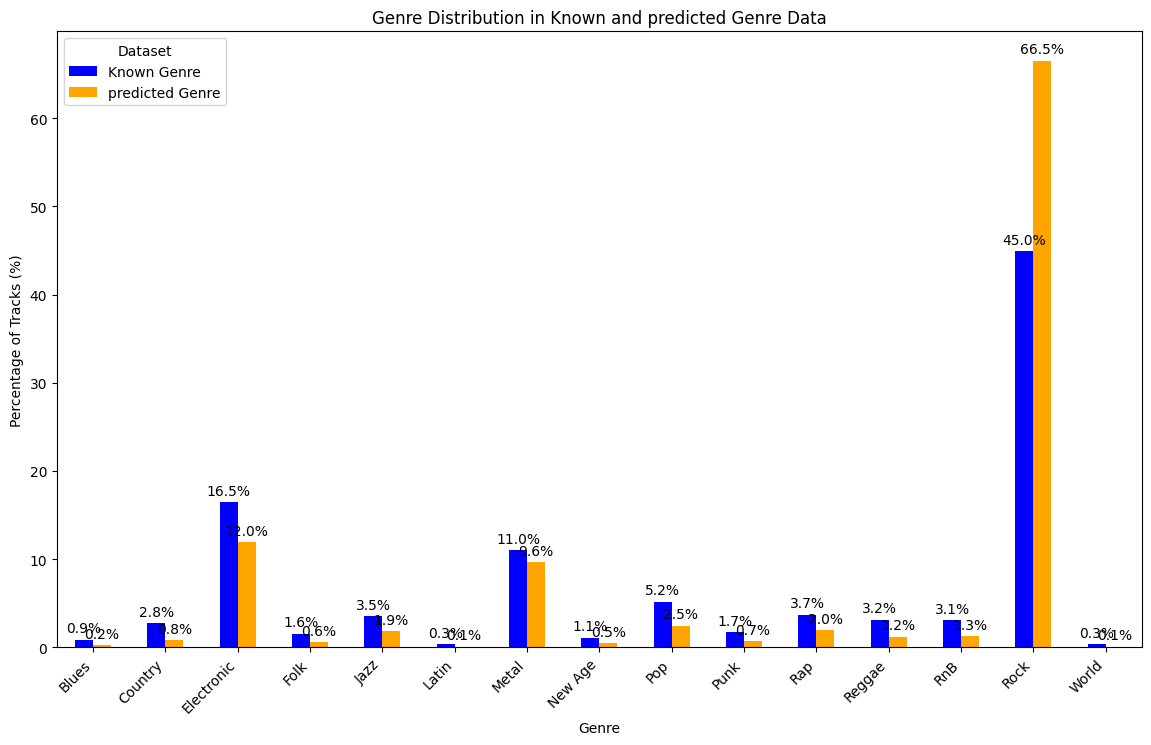

In [42]:

known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)

# Ploting the distributions
plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


The distribution also does not show any significant changes. Rock is still overpredicted. Our primary goal moving forward will be to address this overprediction.

In [43]:
label_encoder = LabelEncoder()
data_predicted_genre['genre'] = label_encoder.fit_transform(data_predicted_genre['genre'])

filtered_data = data_predicted_genre.copy()

filtered_data = filtered_data.drop(columns=columns_to_exclude + ['genre'])

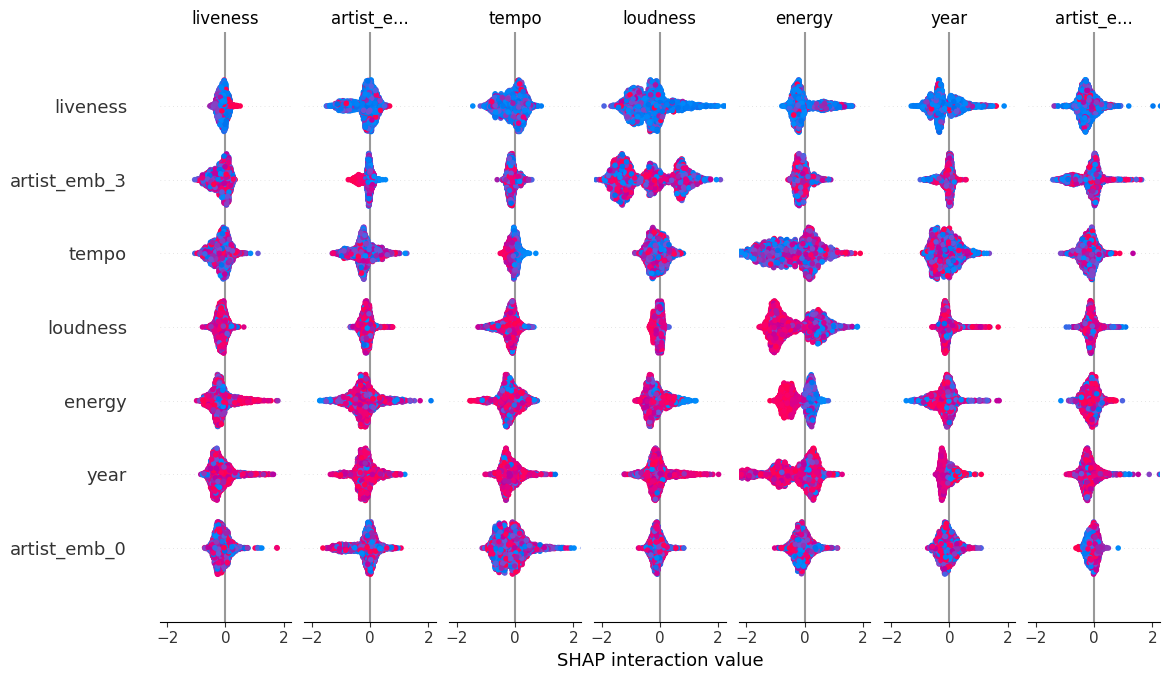

In [44]:

sampled_data_for_shap = filtered_data.sample(frac=0.1, random_state=42)

explainer = shap.TreeExplainer(xgb_model_without_tags)

shap_values = explainer.shap_values(sampled_data_for_shap)


shap.summary_plot(shap_values, sampled_data_for_shap)


**Key Features:**

*   Numerical features like energy, tempo, and year became dominant.
*   Artist embeddings (artist_emb_3, artist_emb_0) also gained prominence, introducing a possible artist-centric bias.

**Insights:**

*   Removing tags shifted focus to musical and temporal features.
*   The feature contributions were more balanced, reducing the rock-centric bias caused by tags.


# 3.Model with adjusted weights

Since the main issue with our models is the overprediction of the rock genre, we will address this directly. We will drastically adjust the weights of the rock genre, which should reduce its overrepresentation in the predictions.

Rock genre weight-0.5


In [47]:

xgb_model_with_regularization = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'
)

if 'rock' in label_encoder.classes_:
    rock_index = label_encoder.transform(['rock'])[0]
else:
    rock_index = None

y_train_series = pd.Series(y_train)
class_weights = y_train_series.value_counts(normalize=True)


sample_weights = y_train_series.apply(lambda x: 1 / class_weights[x] if x != rock_index else 0.5 / class_weights[x])




params = {
    'subsample': 0.7,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.15,
    'gamma': 0.3,
    'colsample_bytree': 0.7,
}

xgb_model_with_regularization.set_params(**params)

xgb_model_with_regularization.fit(X_train, y_train,sample_weight=sample_weights)

print("\nFinal XGBoost Model Parameters:")
for key, value in params.items():
    print(f"{key}: {value}")




Final XGBoost Model Parameters:
subsample: 0.7
n_estimators: 200
max_depth: 6
learning_rate: 0.15
gamma: 0.3
colsample_bytree: 0.7


In [48]:

y_pred_best = xgb_model_with_regularization.predict(X_val)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_val, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Blues       0.50      0.19      0.27        37
     Country       0.62      0.47      0.53       131
  Electronic       0.71      0.74      0.72       735
        Folk       0.56      0.45      0.50        51
        Jazz       0.54      0.41      0.46       150
       Latin       1.00      0.24      0.38        17
       Metal       0.71      0.79      0.75       461
     New Age       0.74      0.44      0.55        39
         Pop       0.42      0.43      0.42       216
        Punk       0.70      0.40      0.51        70
         Rap       0.64      0.51      0.57       175
      Reggae       0.67      0.52      0.59       134
         RnB       0.37      0.35      0.36       123
        Rock       0.76      0.81      0.78      1973
       World       1.00      0.36      0.53        11

    accuracy                           0.70      4323
   macro avg       0.66      0.47 

**Accuracy: 70%**

This is interesting. Drastically changing the weight of the rock genre did not alter the outcome at all. The accuracy remains at 70%. The model likely adjusted its internal weights to counteract the change we applied.

In [49]:
data_unknown_genre = data_unknown_genre.drop(columns=columns_to_drop, errors='ignore')

In [50]:
X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])

if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])

y_pred_unknown = xgb_model_with_regularization.predict(X_unknown)

data_predicted_genre = data_unknown_genre.copy()

predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})



<Figure size 1400x800 with 0 Axes>

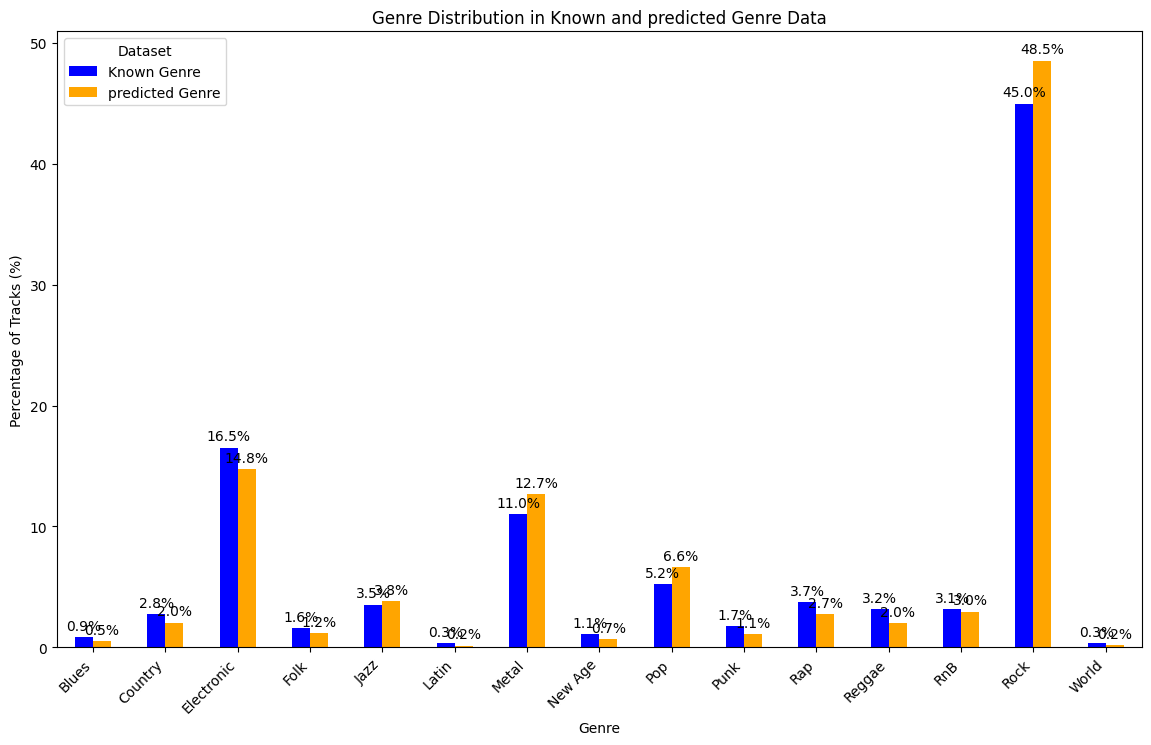

In [51]:

known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)

# Ploting the distributions
plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


The distribution also remains unchanged.

In [52]:
label_encoder = LabelEncoder()
data_predicted_genre['genre'] = label_encoder.fit_transform(data_predicted_genre['genre'])

filtered_data = data_predicted_genre.copy()

filtered_data = filtered_data.drop(columns=columns_to_exclude + ['genre'])

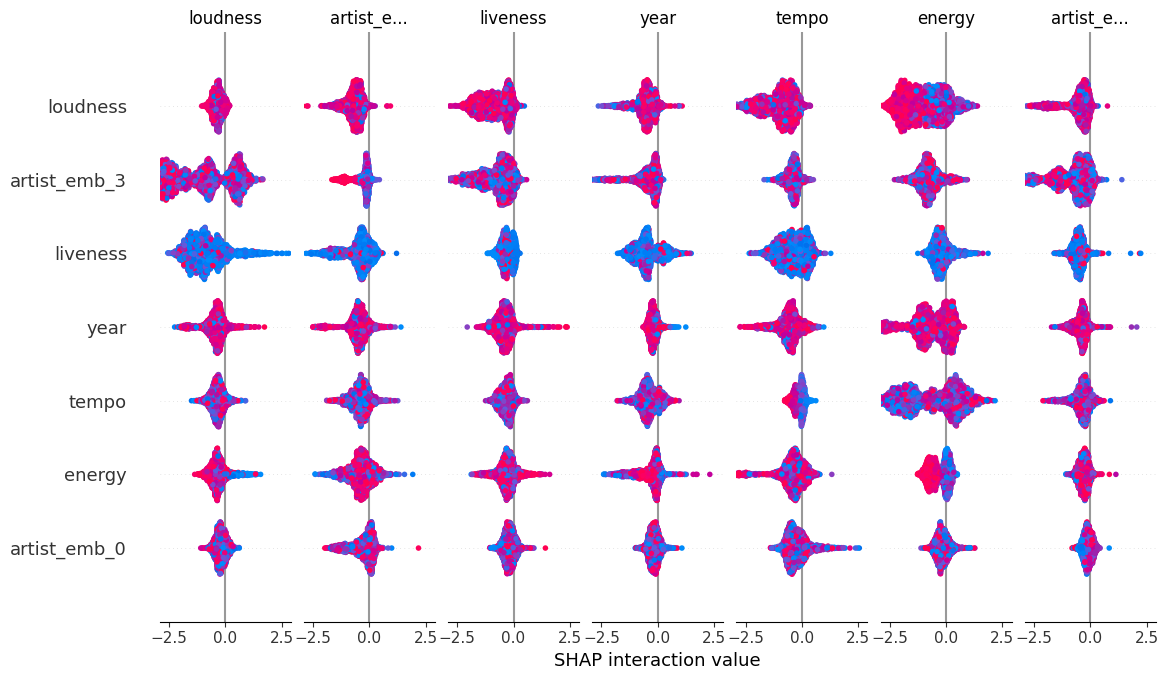

In [53]:



sampled_data_for_shap = filtered_data.sample(frac=0.1, random_state=42)


explainer = shap.TreeExplainer(xgb_model_with_regularization)


shap_values = explainer.shap_values(sampled_data_for_shap)


shap.summary_plot(shap_values, sampled_data_for_shap)




**Key Features:**


*   Adjusted class weights reduced the dominance of features like energy and tempo.
*   Year became more influential, indicating the model relied more on temporal patterns.


**Insights:**


*   Weight adjustments redistributed feature importance but did not completely eliminate biases.
*   The model showed improved balance in predictions.



# 4.Models on resamplde data

It is time to employ more drastic measures. We need to resample the data by removing some of the rock records to reduce rock-centered predictions. This approach may slightly decrease the model's accuracy, as we are discarding valuable data. However, it should result in better weight distributions, enabling the model to predict multiple genres more effectively

## 4.1. Model with only half of rock tracks

First model will be trained without half of rock records.

In [54]:

rock_df = data_known_genre[data_known_genre['genre'] == 'Rock']
non_rock_df = data_known_genre[data_known_genre['genre'] != 'Rock']

rock_sample = rock_df.sample(frac=0.5, random_state=42)

data_resampled = pd.concat([non_rock_df, rock_sample]).reset_index(drop=True)

In [55]:
X = data_resampled.drop(columns=columns_to_drop + columns_to_exclude + ['genre'], errors='ignore')
y = data_resampled['genre']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_resampled, X_val, y_resampled, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [56]:

params = {
    'subsample': 0.7,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.15,
    'gamma': 0.3,
    'colsample_bytree': 0.7
}

xgb_model_on_resampled_data = XGBClassifier(
    **params,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model_on_resampled_data.fit(X_resampled, y_resampled)

print("\nFinal XGBoost Model Parameters:")
for key, value in params.items():
    print(f"{key}: {value}")



Final XGBoost Model Parameters:
subsample: 0.7
n_estimators: 200
max_depth: 6
learning_rate: 0.15
gamma: 0.3
colsample_bytree: 0.7


In [57]:

y_pred_best = xgb_model_on_resampled_data.predict(X_val)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_val, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Blues       0.56      0.16      0.25        31
     Country       0.76      0.41      0.54       116
  Electronic       0.71      0.80      0.75       706
        Folk       0.87      0.37      0.51        71
        Jazz       0.71      0.35      0.47       156
       Latin       0.50      0.06      0.10        18
       Metal       0.81      0.83      0.82       478
     New Age       0.86      0.64      0.73        56
         Pop       0.64      0.33      0.43       240
        Punk       0.74      0.39      0.51        66
         Rap       0.71      0.52      0.60       182
      Reggae       0.83      0.49      0.62       154
         RnB       0.54      0.27      0.36       138
        Rock       0.55      0.82      0.66       925
       World       0.60      0.21      0.32        14

    accuracy                           0.66      3351
   macro avg       0.69      0.44 

**Accuracy: 65%**

The drop in accuracy is primarily due to the model predicting approximately 10% less rock. However, it now predicts significantly more of the other genres. This suggests that we have finally found a solution to the rock bias.

In [58]:
data_unknown_genre = data_unknown_genre.drop(columns=columns_to_drop, errors='ignore')

In [59]:

X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])


if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])


y_pred_unknown = xgb_model_on_resampled_data.predict(X_unknown)


data_predicted_genre = data_unknown_genre.copy()


predicted_genres = label_encoder.inverse_transform(y_pred_unknown)


data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})



<Figure size 1400x800 with 0 Axes>

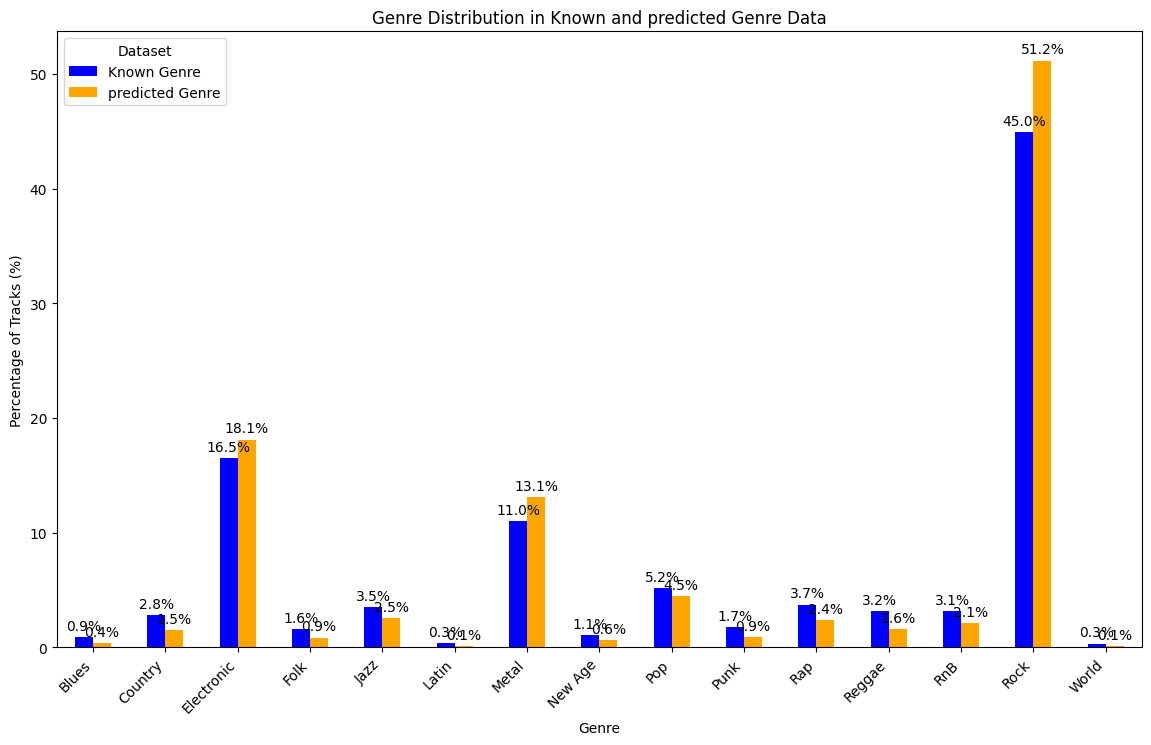

In [60]:


known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)


plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


Finally, the distribution has changed and now appears much more balanced. The amount of rock is now reasonable, and minor genres are better represented. However, one small issue remains: genres like electronic and metal are slightly overrepresented. While the overrepresentation is minimal, we can attempt to fine-tune the distribution further.

In [61]:
label_encoder = LabelEncoder()
data_predicted_genre['genre'] = label_encoder.fit_transform(data_predicted_genre['genre'])

filtered_data = data_predicted_genre.copy()

filtered_data = filtered_data.drop(columns=columns_to_exclude + ['genre'])

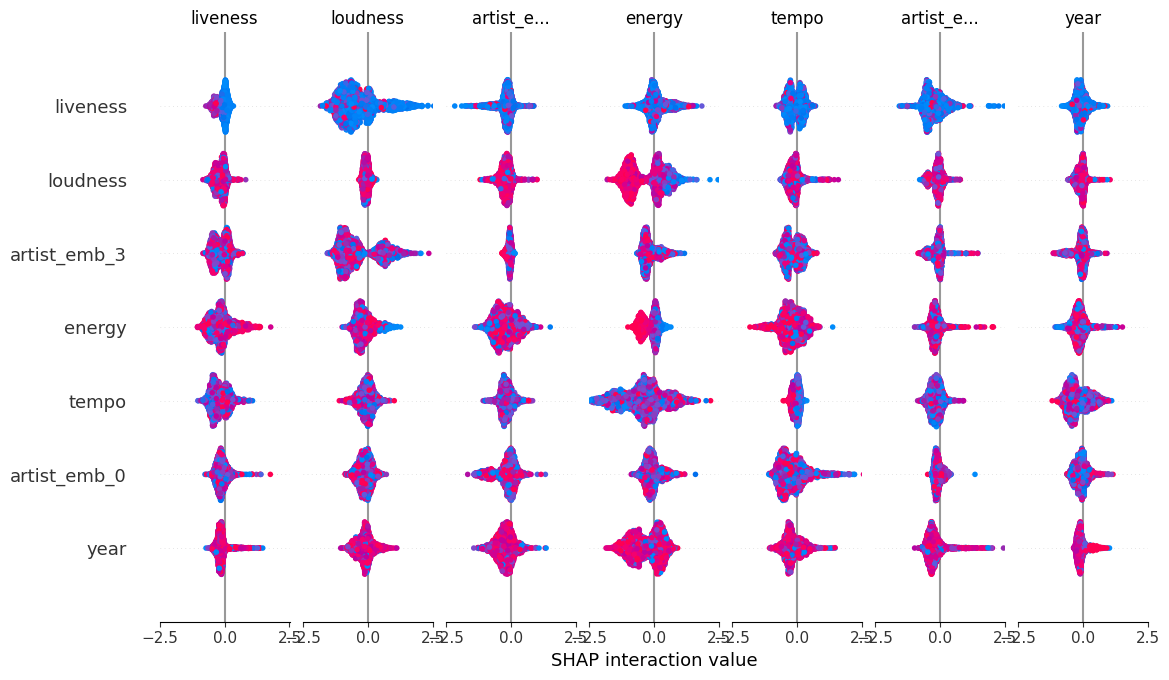

In [62]:

sampled_data_for_shap = filtered_data.sample(frac=0.1, random_state=42)

explainer = shap.TreeExplainer(xgb_model_on_resampled_data)

shap_values = explainer.shap_values(sampled_data_for_shap)

shap.summary_plot(shap_values, sampled_data_for_shap)



**Key Features:**


*   Resampling reduced the dominance of artists embeddings and shifted focus to numerical features like energy, tempo, and loudness.

**Insights:**


*   Resampling improved the balance of feature contributions and reduced genre-specific biases.
*   Numerical features became the main drivers of predictions, which likely improved generalization.


## 4.2. Model on data resamplde to avergae
In this model, we resample our data more aggressively. All genres with more than 1,300 tracks—approximately the average number of tracks per genre—will be reduced to exactly 1,300 tracks. The tracks to be removed are, of course, selected randomly.

In [63]:

avg_tracks_per_genre = 1300


dfs = []

for genre in data_known_genre['genre'].unique():

    genre_df = data_known_genre[data_known_genre['genre'] == genre]
    count = len(genre_df)

    if count > avg_tracks_per_genre:

        genre_sampled = genre_df.sample(n=avg_tracks_per_genre, random_state=42)
    else:

        genre_sampled = genre_df

    dfs.append(genre_sampled)

data_resampled = pd.concat(dfs, ignore_index=True)

data_resampled = data_resampled.sample(frac=1, random_state=42).reset_index(drop=True)

print(data_resampled['genre'].value_counts())


genre
Metal         1300
Rock          1300
Electronic    1300
Pop           1124
Rap            805
Jazz           764
Reggae         681
RnB            678
Country        601
Punk           375
Folk           338
New Age        237
Blues          188
Latin           75
World           72
Name: count, dtype: int64


In [64]:
X = data_resampled.drop(columns=columns_to_drop+columns_to_exclude+['genre'], errors='ignore')
y = data_resampled['genre']

In [65]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [66]:
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [67]:


xgb_model_with_data_average_resample = XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'
)

params = {
    'subsample': 0.7,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.15,
    'gamma': 0.3,
    'colsample_bytree': 0.7
}

xgb_model_with_data_average_resample.set_params(**params)

xgb_model_with_data_average_resample.fit(X_train, y_train)

y_pred = xgb_model_with_data_average_resample.predict(X_val)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nFinal XGBoost Model Parameters:")
for key, value in params.items():
    print(f"{key}: {value}")



Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.16      0.24        38
           1       0.64      0.47      0.54       137
           2       0.55      0.68      0.61       240
           3       0.75      0.54      0.63        70
           4       0.48      0.46      0.47       140
           5       1.00      0.47      0.64        15
           6       0.70      0.82      0.76       245
           7       0.82      0.54      0.65        57
           8       0.46      0.53      0.50       254
           9       0.73      0.48      0.58        62
          10       0.62      0.53      0.57       170
          11       0.71      0.50      0.59       143
          12       0.43      0.37      0.40       127
          13       0.38      0.53      0.45       255
          14       0.75      0.20      0.32        15

    accuracy                           0.55      1968
   macro avg       0.63      0.49      0.53      1968
we

In [68]:
y_pred_best = xgb_model_with_data_average_resample.predict(X_val)
print("Classification Report for Best XGBoost Model:")
print(classification_report(y_val, y_pred_best, target_names=label_encoder.classes_))

Classification Report for Best XGBoost Model:
              precision    recall  f1-score   support

       Blues       0.46      0.16      0.24        38
     Country       0.64      0.47      0.54       137
  Electronic       0.55      0.68      0.61       240
        Folk       0.75      0.54      0.63        70
        Jazz       0.48      0.46      0.47       140
       Latin       1.00      0.47      0.64        15
       Metal       0.70      0.82      0.76       245
     New Age       0.82      0.54      0.65        57
         Pop       0.46      0.53      0.50       254
        Punk       0.73      0.48      0.58        62
         Rap       0.62      0.53      0.57       170
      Reggae       0.71      0.50      0.59       143
         RnB       0.43      0.37      0.40       127
        Rock       0.38      0.53      0.45       255
       World       0.75      0.20      0.32        15

    accuracy                           0.55      1968
   macro avg       0.63      0.49 

**Accuracy-54%**

The drop in accuracy is too significant and affects not only the rock genre but also the minor genres. We likely removed too much valuable data.

In [69]:
data_unknown_genre = data_unknown_genre.drop(columns=columns_to_drop, errors='ignore')

In [70]:

X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])

if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])

y_pred_unknown = xgb_model_with_data_average_resample.predict(X_unknown)

data_predicted_genre = data_unknown_genre.copy()

predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})



<Figure size 1400x800 with 0 Axes>

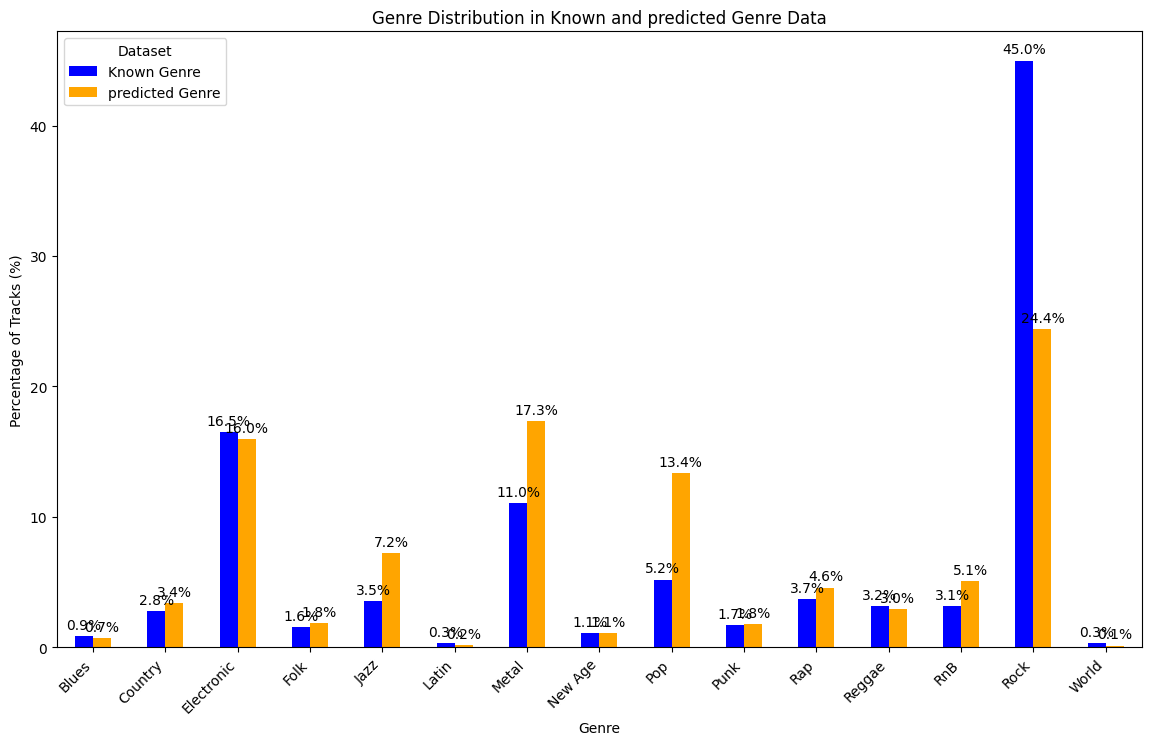

In [71]:

known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)

plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


The distribution is now skewed in another way: the rock genre is significantly underfitted, while other genres are overfitted. This resampling was clearly too aggressive.

In [72]:
label_encoder = LabelEncoder()
data_predicted_genre['genre'] = label_encoder.fit_transform(data_predicted_genre['genre'])

filtered_data = data_predicted_genre.copy()

filtered_data = filtered_data.drop(columns=columns_to_exclude + ['genre'])

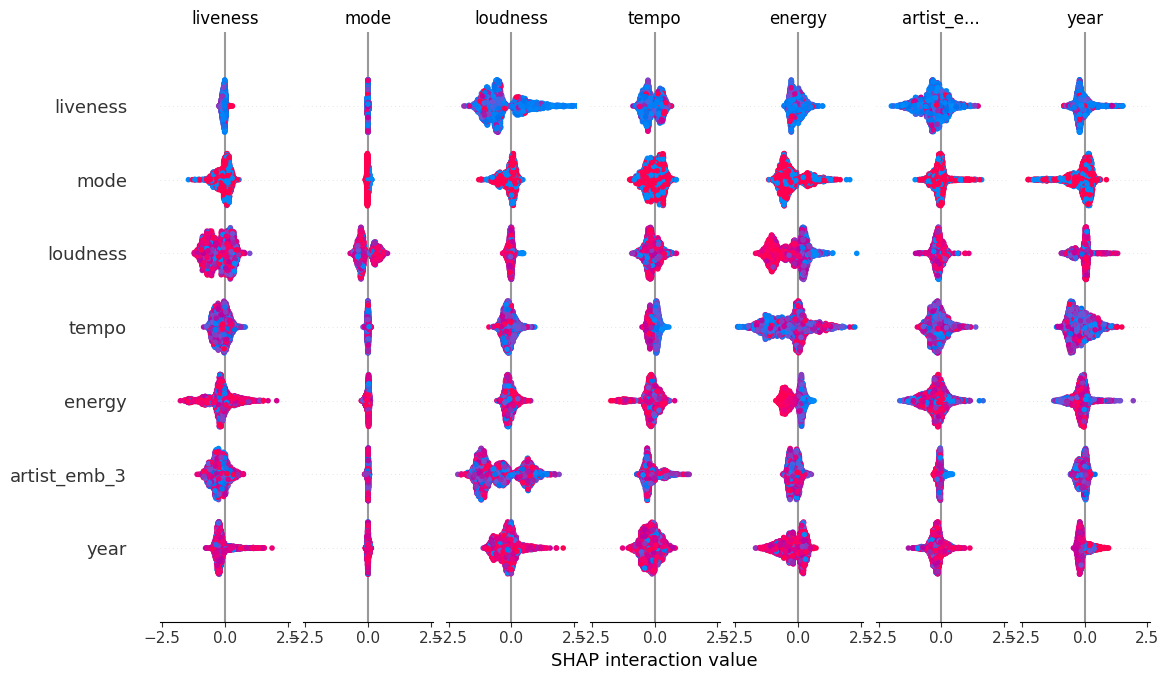

In [73]:


sampled_data_for_shap = filtered_data.sample(frac=0.1, random_state=42)

explainer = shap.TreeExplainer(xgb_model_with_data_average_resample)

shap_values = explainer.shap_values(sampled_data_for_shap)

shap.summary_plot(shap_values, sampled_data_for_shap)



**Key Features:**

*   SHAP values were evenly distributed across numerical features like energy, tempo, year, and loudness.
*   Embeddings had minimal influence.

**Insights:**

*   The reduced reliance on embeddings (tags and artists) minimized genre biases, resulting in a more fair representation of all genres, even a bit to fair.

# 5.Final predictions

The model trained on resampled data is clearly the best one. The data distribution is the closest to what we can reasonably expect from this dataset. It achieves the best balance between accuracy—which tends to favor always predicting the rock genre—and a distribution where all genres are properly represented.

In [74]:

X_unknown = data_unknown_genre.drop(columns=columns_to_exclude + ['genre'])


if 'predicted_genre' in X_unknown.columns:
    X_unknown = X_unknown.drop(columns=['predicted_genre'])

y_pred_unknown = xgb_model_on_resampled_data.predict(X_unknown)

data_predicted_genre = data_unknown_genre.copy()

predicted_genres = label_encoder.inverse_transform(y_pred_unknown)

data_predicted_genre['predicted_genre'] = predicted_genres

data_predicted_genre = data_predicted_genre.drop(columns=["genre"])
data_predicted_genre = data_predicted_genre.rename(columns={"predicted_genre": "genre"})



<Figure size 1400x800 with 0 Axes>

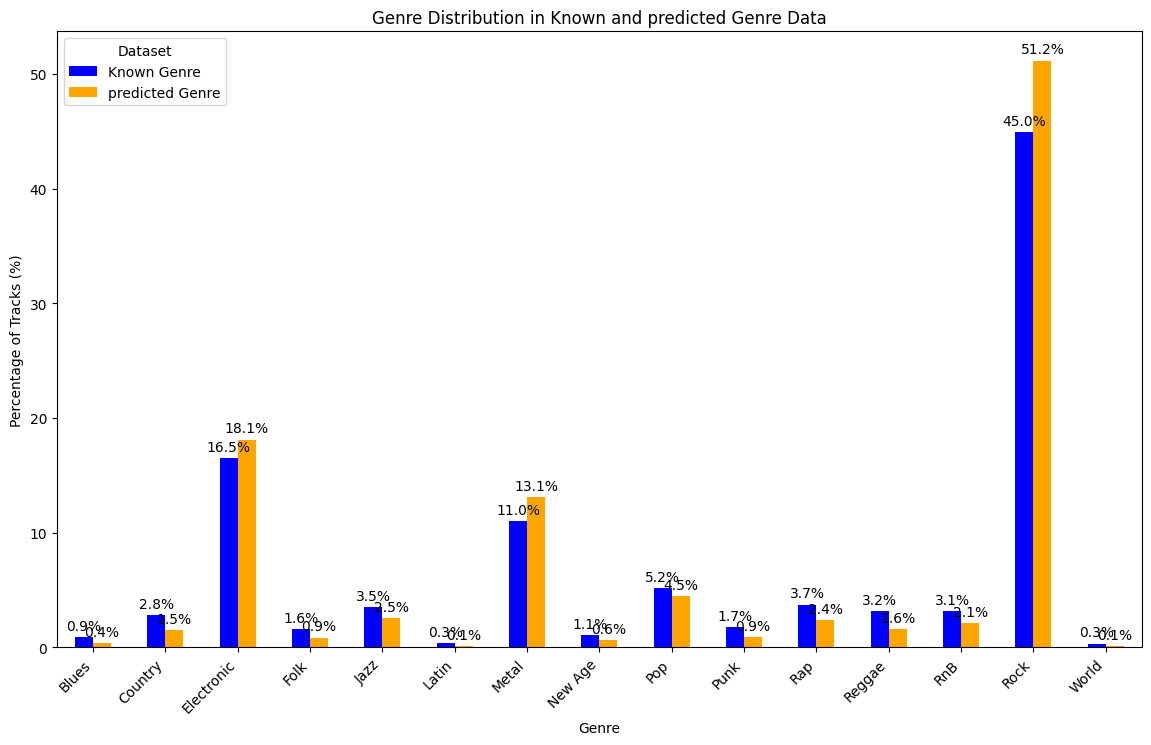

In [75]:

known_genre_counts = data_known_genre['genre'].value_counts(normalize=True) * 100
predicted_genre_counts = data_predicted_genre['genre'].value_counts(normalize=True) * 100

combined_df = pd.DataFrame({
    'Known Genre': known_genre_counts,
    'predicted Genre': predicted_genre_counts
}).fillna(0)

# Ploting the distributions
plt.figure(figsize=(14, 8))
ax = combined_df.plot(kind='bar', stacked=False, figsize=(14, 8), color=['blue', 'orange'])
plt.title('Genre Distribution in Known and predicted Genre Data')
plt.xlabel('Genre')
plt.ylabel('Percentage of Tracks (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

plt.show()


In [76]:
data_predicted_genre.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'year', 'duration_s', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'artist_encoded', 'artist_emb_0', 'artist_emb_1', 'artist_emb_2',
       'artist_emb_3', 'artist_emb_4', 'artist_emb_5', 'artist_emb_6',
       'artist_emb_7', 'artist_emb_8', 'artist_emb_9', 'artist_emb_10',
       'artist_emb_11', 'artist_emb_12', 'artist_emb_13', 'artist_emb_14',
       'artist_emb_15', 'speechiness', 'instrumentalness', 'acousticness',
       'genre'],
      dtype='object')

In [77]:
artist_emb_columns=['artist_emb_0', 'artist_emb_1', 'artist_emb_2',
       'artist_emb_3', 'artist_emb_4', 'artist_emb_5', 'artist_emb_6',
       'artist_emb_7', 'artist_emb_8', 'artist_emb_9', 'artist_emb_10',
       'artist_emb_11', 'artist_emb_12', 'artist_emb_13', 'artist_emb_14',
       'artist_emb_15']

tag_emb_columns=['tag_emb_0', 'tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4','tag_emb_5','tag_emb_6','tag_emb_7']

In [78]:
data_predicted_genre = data_predicted_genre.drop(columns=artist_emb_columns, errors='ignore')


In [79]:
data_predicted_genre.columns


Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'year', 'duration_s', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'artist_encoded', 'speechiness', 'instrumentalness', 'acousticness',
       'genre'],
      dtype='object')

In [80]:
data_predicted_genre.to_csv("/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/Predicted_genre.csv", index=False)

In [81]:
data_known_genre.columns

Index(['track_id', 'name', 'artist', 'spotify_preview_url', 'spotify_id',
       'genre', 'year', 'duration_s', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'liveness', 'valence', 'tempo', 'time_signature',
       'tag_emb_0', 'tag_emb_1', 'tag_emb_2', 'tag_emb_3', 'tag_emb_4',
       'tag_emb_5', 'tag_emb_6', 'tag_emb_7', 'artist_encoded', 'artist_emb_0',
       'artist_emb_1', 'artist_emb_2', 'artist_emb_3', 'artist_emb_4',
       'artist_emb_5', 'artist_emb_6', 'artist_emb_7', 'artist_emb_8',
       'artist_emb_9', 'artist_emb_10', 'artist_emb_11', 'artist_emb_12',
       'artist_emb_13', 'artist_emb_14', 'artist_emb_15', 'speechiness',
       'instrumentalness', 'acousticness'],
      dtype='object')

In [82]:
data_known_genre=data_known_genre.drop(columns=artist_emb_columns+tag_emb_columns, errors='ignore')

We can now export our data with all genres assigned.

In [83]:
data_known_genre['isPred'] = 0
data_predicted_genre['isPred'] = 1

merged_data = pd.concat([data_known_genre, data_predicted_genre], ignore_index=True)

shuffled_data = merged_data.sample(frac=1, random_state=42).reset_index(drop=True)

shuffled_data.to_csv("/content/drive/MyDrive/Spotify_Recommendation_Engine/PREPROCESSED_DATA/DATA_preprocessed.csv", index=False)

print("DataFrames merged, shuffled, and saved to 'DATA_preprocessed.csv'.")


DataFrames merged, shuffled, and saved to 'DATA_preprocessed.csv'.
